In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define constants
tubelet_size = 2
crop_size = 224
in_channels = 3
num_frames = 16
patch_size = 16
num_masks = num_frames // tubelet_size
alpha = 0.5 # for overlaying masks
# Define colors for masks
colors = [
    [1, 0, 0],  # Red
    [0, 1, 0],  # Green
    [0, 0, 1],  # Blue
    [1, 1, 0],  # Yellow
    [1, 0, 1],  # Magenta
    [0, 1, 1],  # Cyan
    [0.5, 0.5, 0.5],  # Gray
    [1, 0.5, 0],  # Orange
]
CLIP_NUM = 4

one clip torch.Size([16, 224, 224, 3])


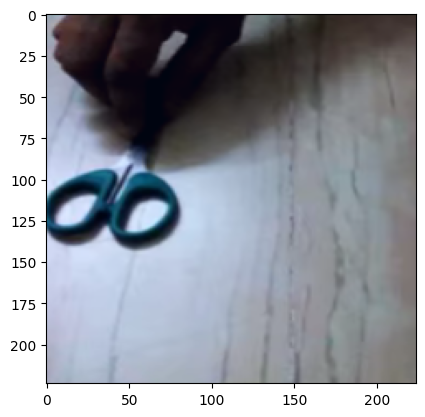

masks 8 of size torch.Size([8, 14, 14])


In [3]:
read_one_clip_norm = True

if read_one_clip_norm:
    one_clip_norm = torch.load('one_clip_norm.pt', map_location='cpu')
    print('one clip', one_clip_norm.size())
    plt.imshow(one_clip_norm[0])
    plt.show()
else:
    # Load tensors from the file tensors.pth
    loaded_tensors = torch.load('tensors.pth', map_location='cpu')
    clips = loaded_tensors['tensor1']
    print('clips', clips.size())
    # 3x16x224x224 -> 16x224x224x3
    clip = clips[CLIP_NUM].permute(1, 2, 3, 0)
    # Normalize the `clips` tensor to the range [0, 1]
    clips_min = clip.min()
    clips_max = clip.max()
    one_clip_norm = (clip - clips_min) / (clips_max - clips_min)
    print('one clip', one_clip_norm.size())

# Load masks from the file
masks_list = torch.load('masks.pt', map_location='cpu')
print('masks', len(masks_list), 'of size', masks_list[0].shape)

In [24]:
def create_mask_for_original_tensor(mask, original_shape, tubelet_size=2, patch_size=16):
    original_mask = torch.ones(original_shape)
    _, H, W = mask.shape

    # Iterate over the mask tensor to identify zeroed patches
    for t in range(mask.shape[0]):
        for h in range(H):
            for w in range(W):
                if mask[t, h, w] == 0:
                    # Calculate the corresponding indices in the original tensor
                    t_start = t * tubelet_size
                    t_end = t_start + tubelet_size
                    h_start = h * patch_size
                    h_end = h_start + patch_size
                    w_start = w * patch_size
                    w_end = w_start + patch_size
                    
                    original_mask[t_start:t_end, h_start:h_end, w_start:w_end, :] = 0
    return original_mask

In [25]:
def visualize_frames_with_black_mask(one_clip, original_mask, num_frames=16):
    # Create a figure to visualize the frames
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))

    # Plot frames from clips with the corresponding masks
    for i in range(num_frames):
        frame = one_clip[i]
        mask = original_mask[i]
        
        # Create a masked frame by applying the mask
        masked_frame = frame * mask

        # Convert tensors to numpy arrays for plotting
        frame_np = frame.numpy()
        masked_frame_np = masked_frame.numpy()
        
        # Plot the original frame
        ax = axes[i // 4, i % 4]
        ax.imshow(frame_np)
        ax.set_title(f'Frame {i} - Original')

        # Overlay the mask on the frame
        ax.imshow(masked_frame_np, alpha=0.8)
        ax.set_title(f'Frame {i} - Masked')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [26]:
def visualize_frames_with_colored_masks(one_clip_norm, list_of_original_masks, colors, alpha=0.3, tubelet_size=2, in_channels=3, num_frames=16):
    # Create a figure to visualize the frames
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))

    # Plot frames from clips with the corresponding masks
    for i in range(num_frames):
        frame = one_clip_norm[i].numpy()
        
        # Plot the original frame
        ax = axes[i // 4, i % 4]
        ax.imshow(frame)
        ax.set_title(f'Frame {i}')
        ax.axis('off')
        
        # Overlay each mask with its own color
        for mask_idx, original_mask in enumerate(list_of_original_masks):
            mask_frame_idx = i // tubelet_size  # Adjust the frame index for the mask
            if mask_frame_idx < original_mask.shape[0]:
                mask_np = original_mask[mask_frame_idx].numpy()[:, :, 0]  # Extract the mask for a single frame

                # Create an RGBA image with the mask color
                colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 4)) # 4 is for RGBA channels
                for j in range(in_channels):
                    colored_mask[:, :, j] = mask_np * colors[mask_idx][j]
                colored_mask[:, :, 3] = mask_np * alpha  # Set alpha channel based on the mask and provided alpha
                
                ax.imshow(colored_mask)  # Overlay the mask

    plt.tight_layout()
    plt.show()


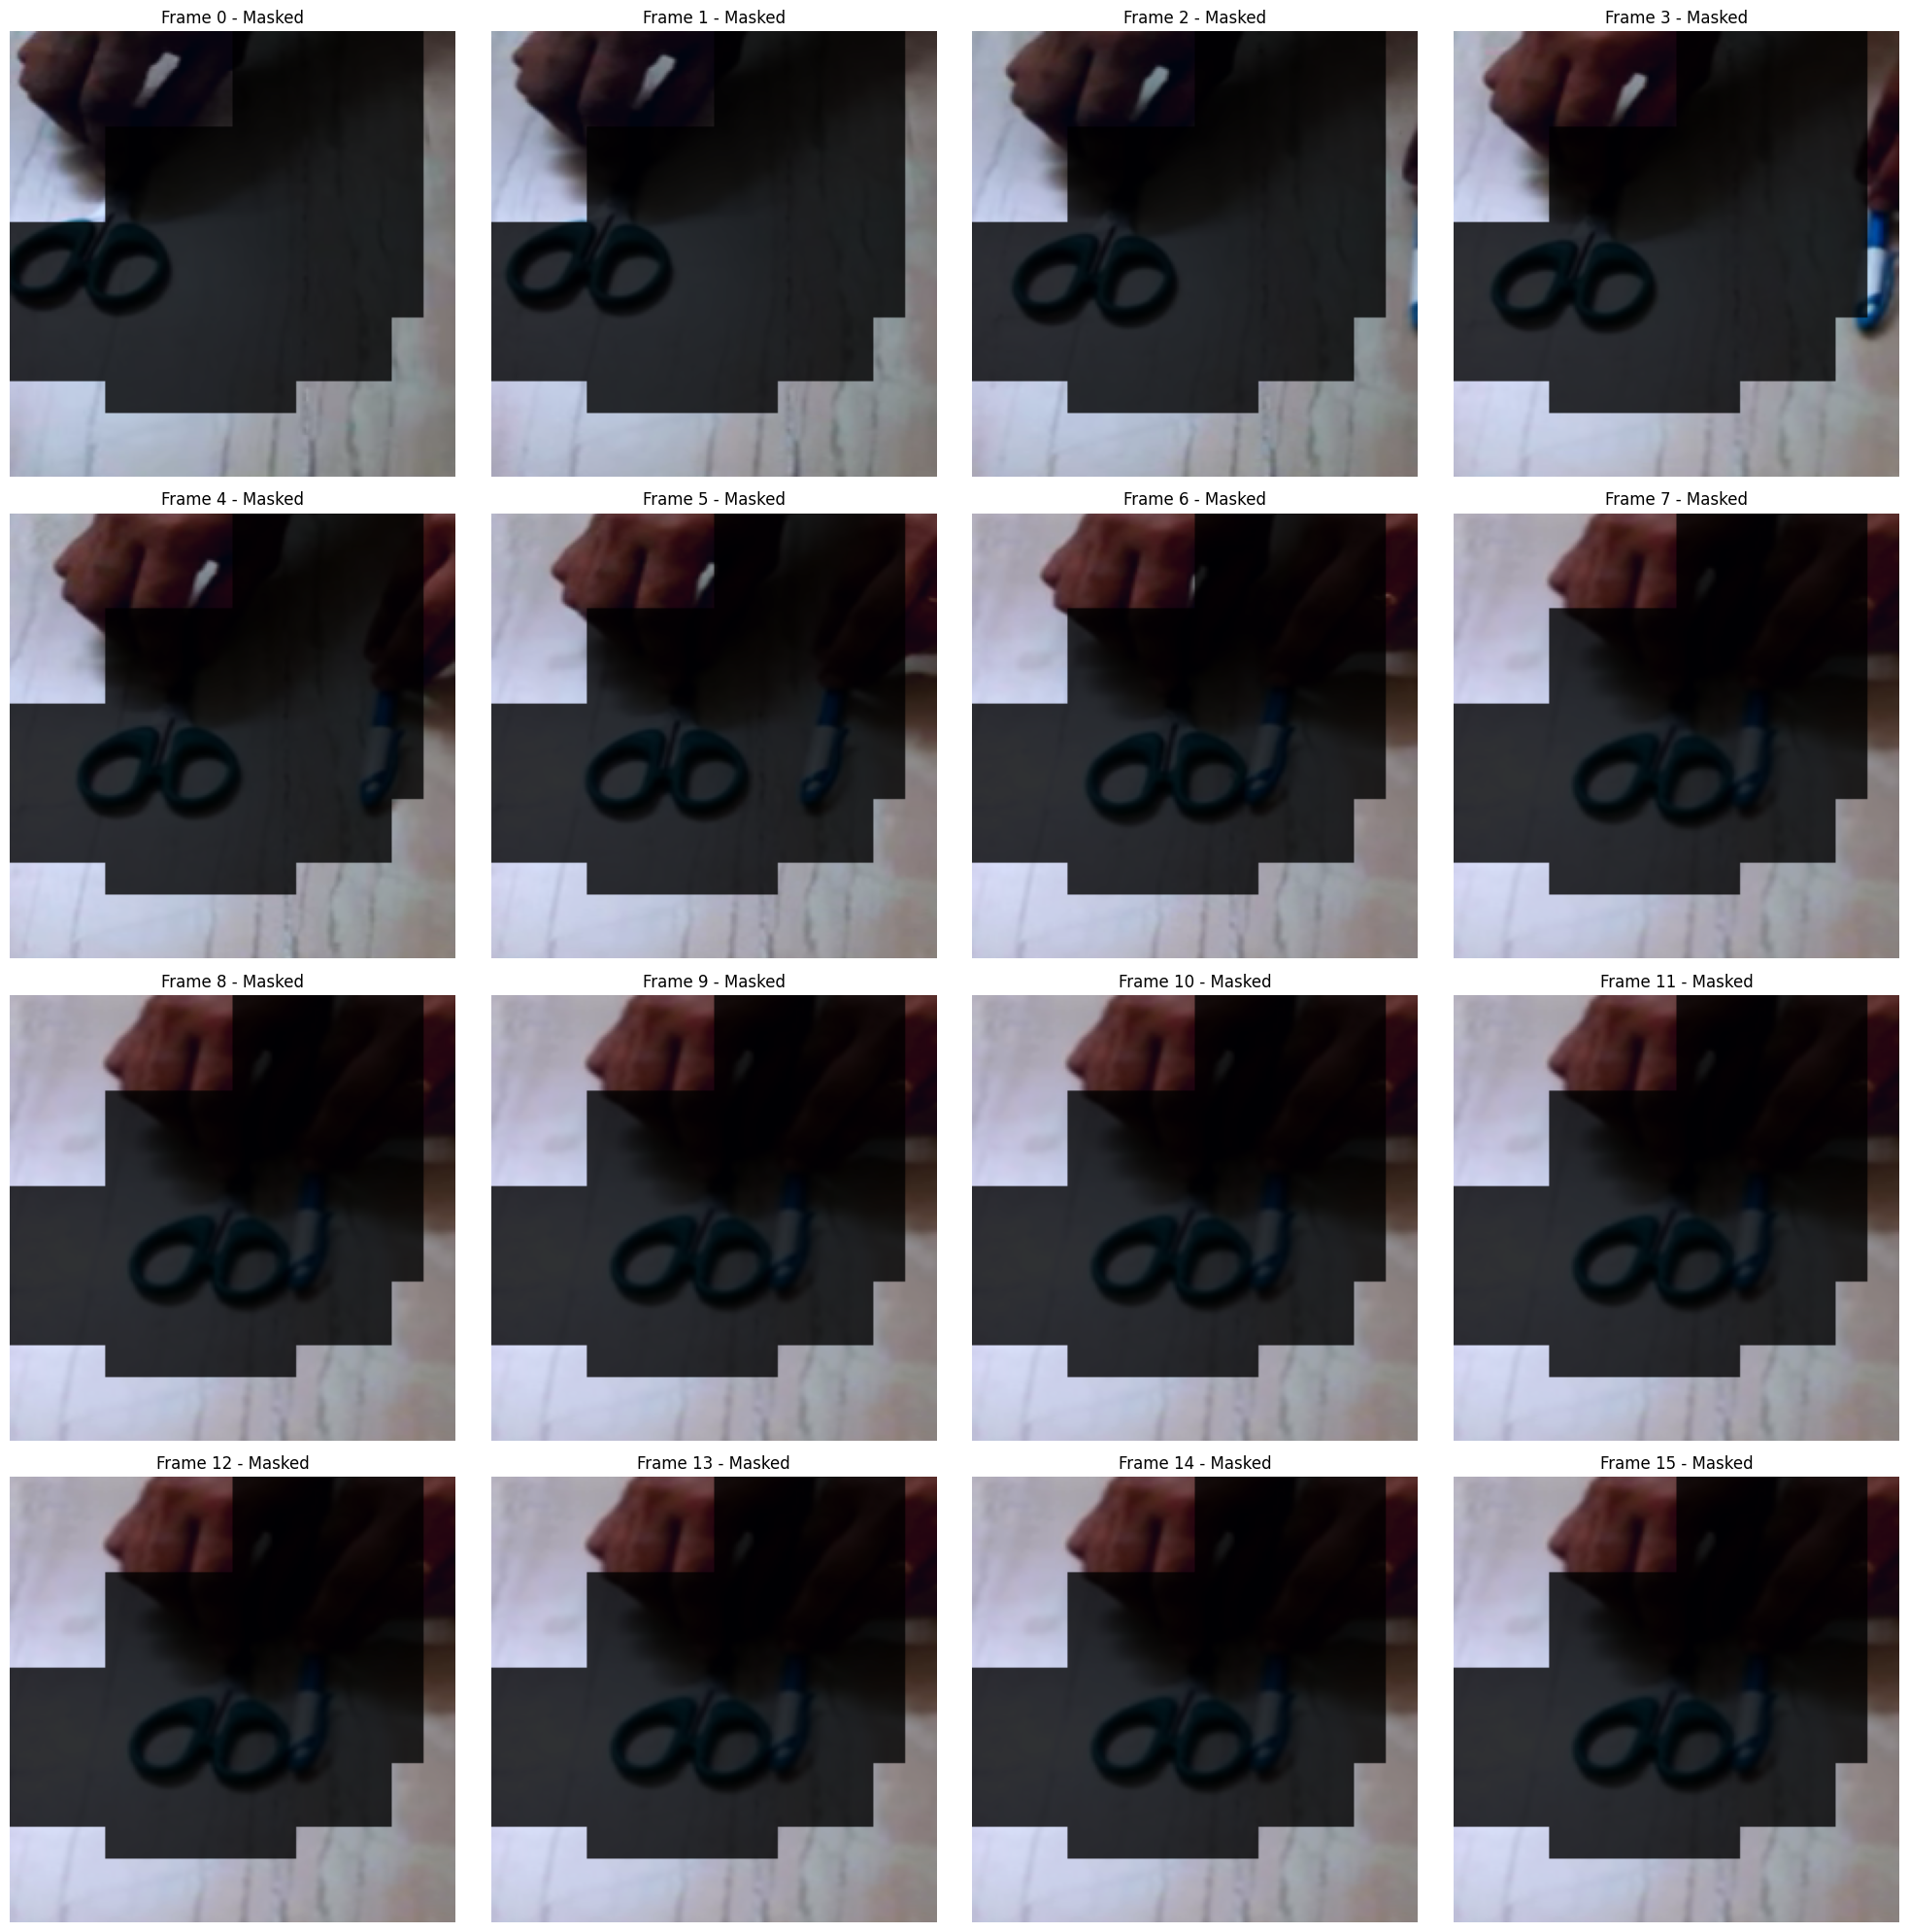

In [27]:
whole_mask = torch.ones_like(masks_list[0])
for mask in masks_list:
    whole_mask *= mask

original_mask = create_mask_for_original_tensor(whole_mask, one_clip_norm.shape, tubelet_size, patch_size)
visualize_frames_with_black_mask(one_clip_norm, original_mask, num_frames)

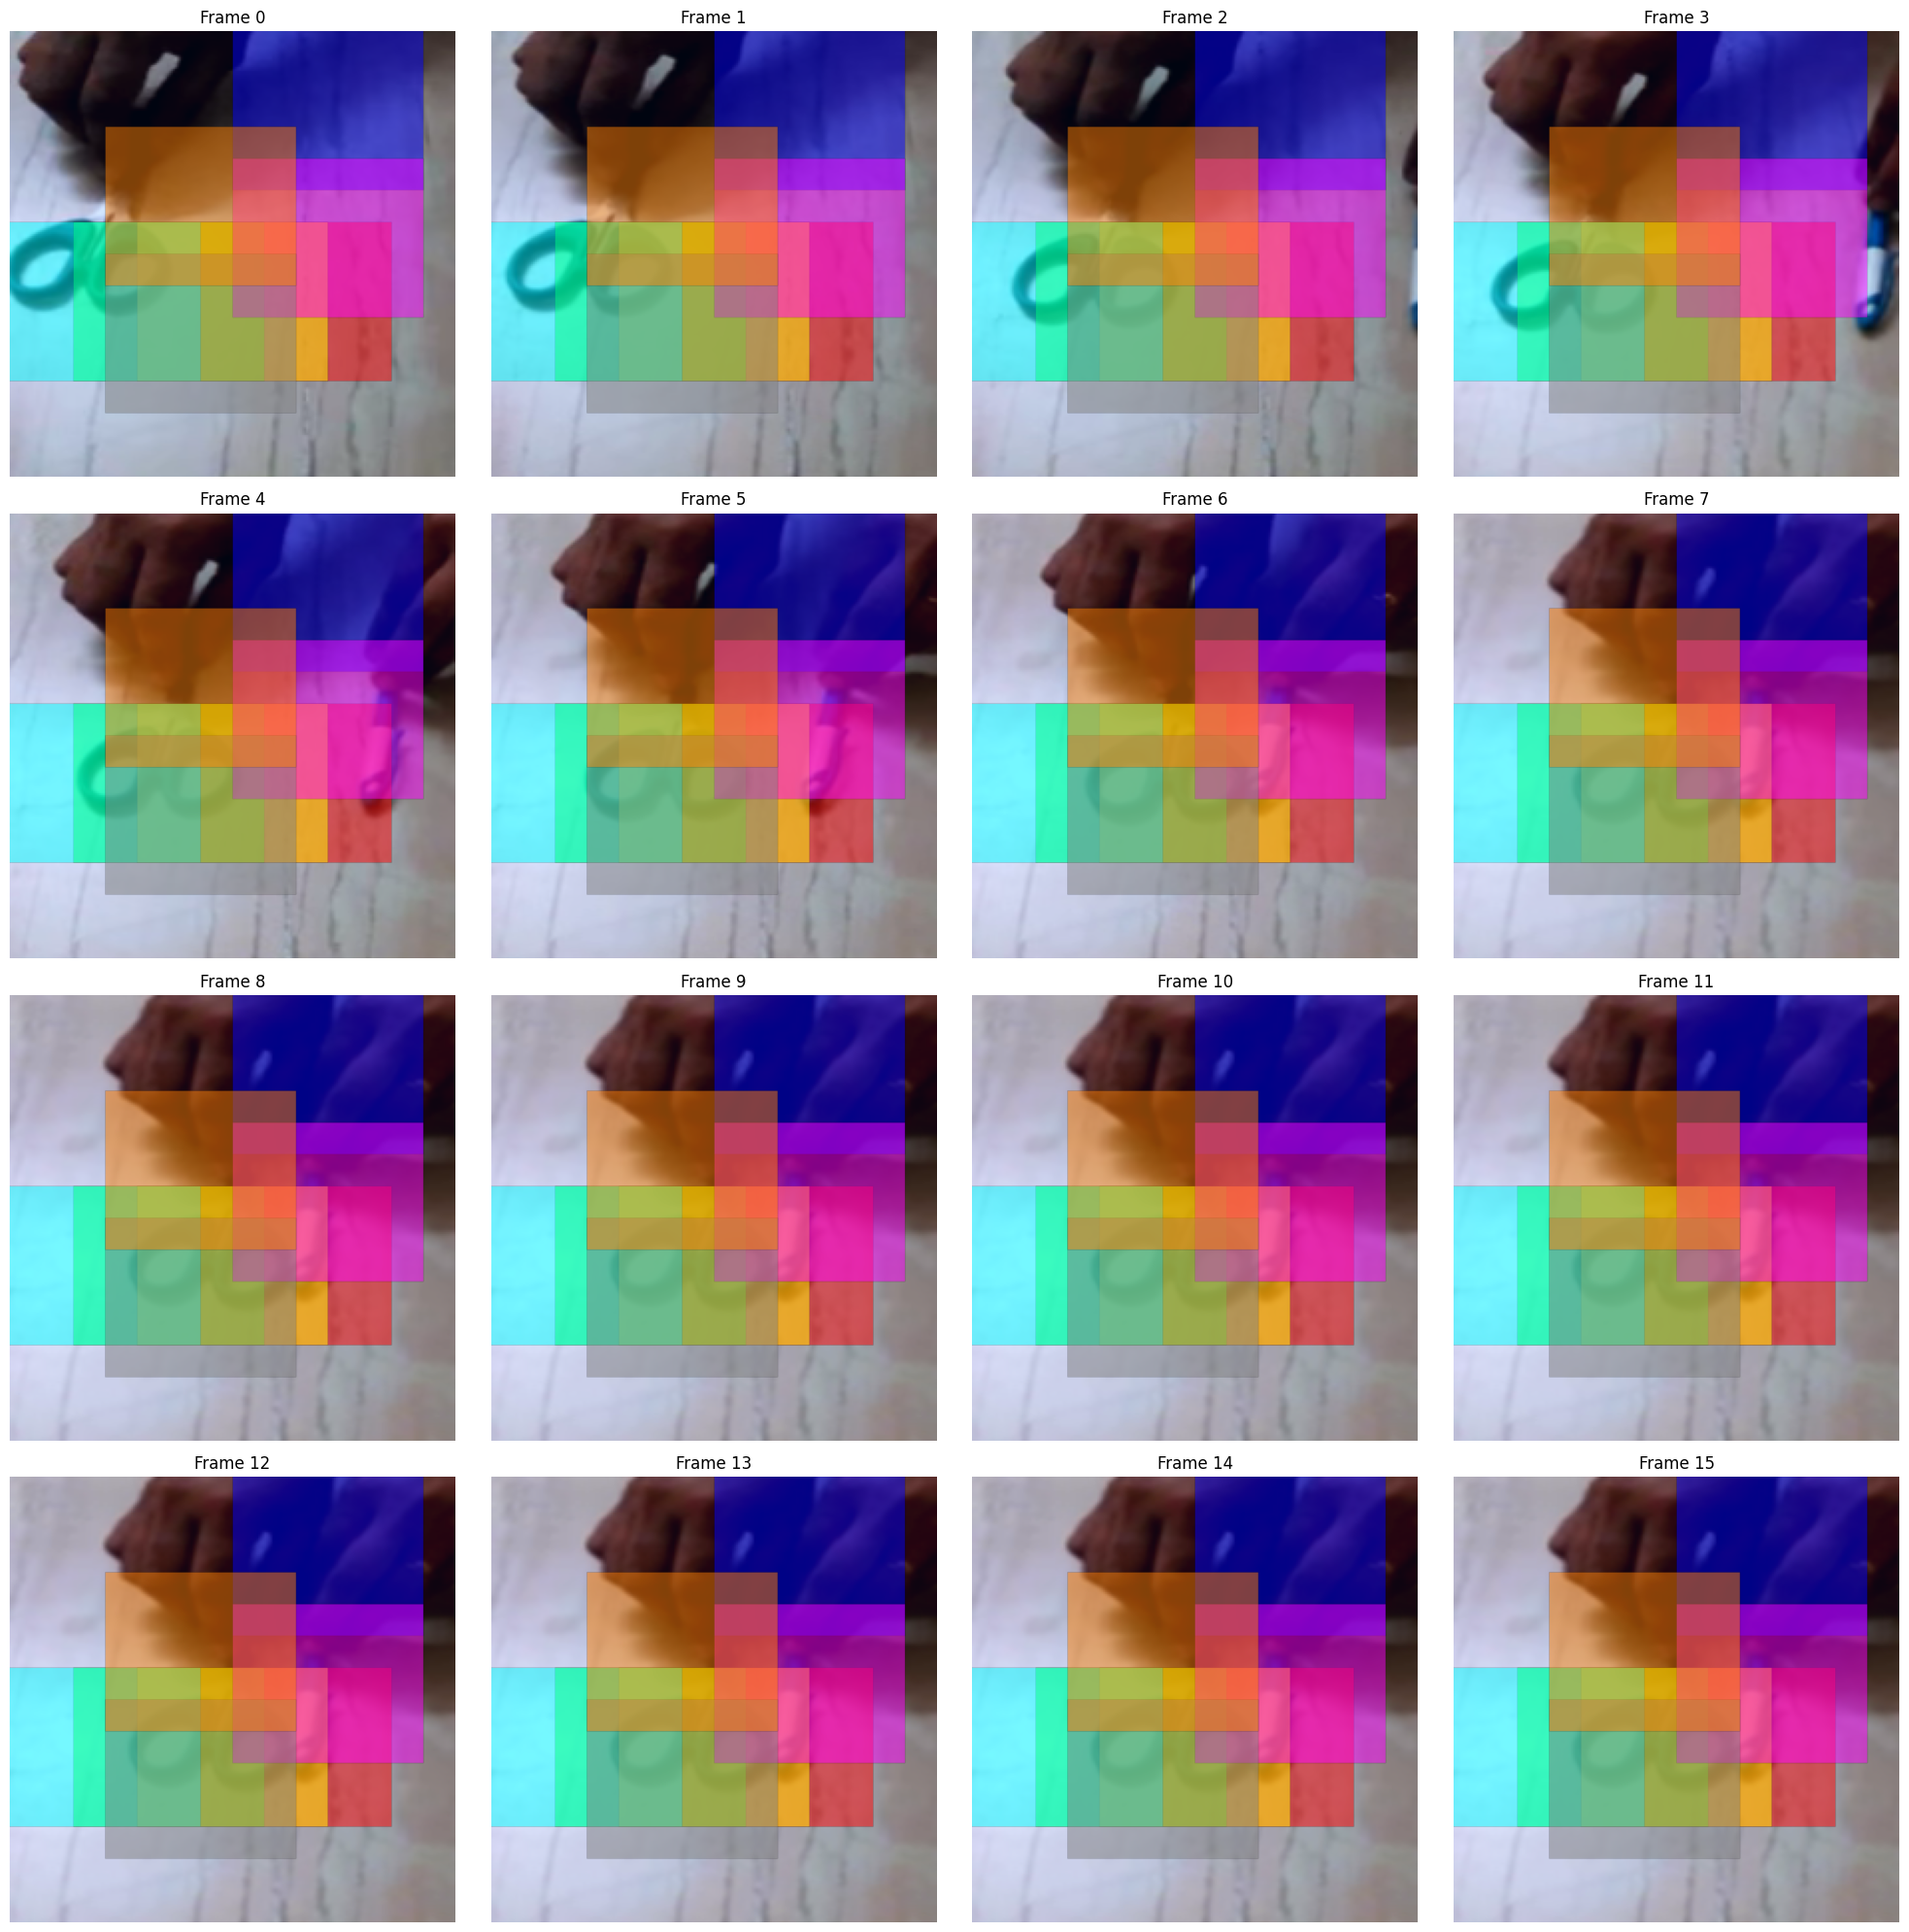

In [28]:
# Visualize the frames and masks
# (1 - x) is done for visualization only
visualize_frames_with_colored_masks(one_clip_norm, 
                                    [1 - create_mask_for_original_tensor(mask, one_clip_norm.shape, tubelet_size, patch_size) for mask in masks_list],
                                    colors, 
                                    alpha, tubelet_size, in_channels, num_frames
)